### LightGBM + ADSTuner
* added feature engineering
* added year, removed temp
* removing day I got the best results. (The range of days in the train set don't match with test set)


In [1]:
import pandas as pd
import numpy as np

import catboost as cat

# to use ADSTuner
from ads.hpo.search_cv import ADSTuner
from ads.hpo.stopping_criterion import *
from ads.hpo.distributions import *

# to encode categoricals
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import make_scorer

import seaborn as sns
import matplotlib.pyplot as plt

# see utils.py
from utils import add_features, rmsle, train_encoders, apply_encoders
from utils import show_tuner_results, show_categoricals

# set seaborn look&feel
sns.set()

In [2]:
# globals and load train dataset

STUDY_NAME = "Bike sharing-cat1"

# number of folds for K-fold cv in ADSTuner
FOLDS = 7

# in secs
TIME_BUDGET = 3600

FILE_TRAIN = "train.csv"
FILE_TEST = "test.csv"

In [3]:
# load train dataset
data_orig = pd.read_csv(FILE_TRAIN)

#
# add features
#
data_extended = add_features(data_orig)

# have a look
data_extended.tail()

datetime  season  holiday  workingday  weather   temp  \
10881 2012-12-19 19:00:00       4        0           1        1  15.58   
10882 2012-12-19 20:00:00       4        0           1        1  14.76   
10883 2012-12-19 21:00:00       4        0           1        1  13.94   
10884 2012-12-19 22:00:00       4        0           1        1  13.94   
10885 2012-12-19 23:00:00       4        0           1        1  13.12   

        atemp  humidity  windspeed  casual  registered  count  hour  year  
10881  19.695        50    26.0027       7         329    336    19  2012  
10882  17.425        57    15.0013      10         231    241    20  2012  
10883  15.910        61    15.0013       4         164    168    21  2012  
10884  17.425        61     6.0032      12         117    129    22  2012  
10885  16.665        66     8.9981       4          84     88    23  2012

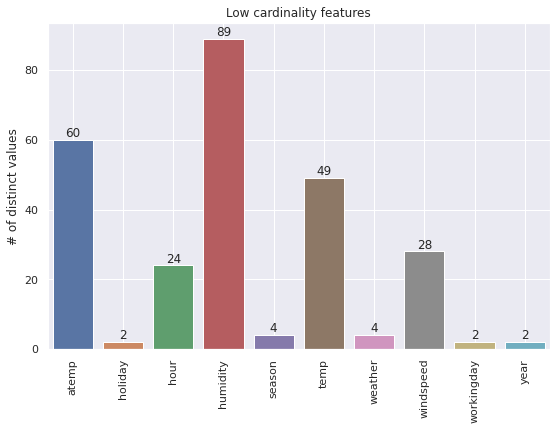

In [4]:
show_categoricals(data_extended, thr=100)

In [5]:
# ok, we will treat as categorical: holiday, hour, season, weather, windspeed, workingday, year

In [6]:
all_columns = data_extended.columns

# cols to be ignored
# atemp and temp are strongly correlated (0.98) we're taking only one
del_columns = ["datetime", "casual", "registered", "temp"]

TARGET = "count"
cat_cols = ["season", "holiday", "workingday", "weather", "windspeed", "hour", "year"]
num_cols = list(set(all_columns) - set([TARGET]) - set(del_columns) - set(cat_cols))
features = sorted(cat_cols + num_cols)

print("All columns:", len(all_columns))
print("Ignored columns:", len(del_columns))
print("Target:", len([TARGET]))
print("Categorical columns:", len(cat_cols))
print("Numerical columns:", len(num_cols))
print("All the features", len(features))

All columns: 14
Ignored columns: 4
Target: 1
Categorical columns: 7
Numerical columns: 2
All the features 9


In [7]:
# drop ignored columns
data_used = data_extended.drop(del_columns, axis=1)

In [8]:
# let's code categorical
# windspeed need a special treatment
le_list = train_encoders(data_extended)

# coding
data_used = apply_encoders(data_used, le_list)

# define indexes for cat_cols
# cat boost want indexes
cat_columns_idxs = [i for i, col in enumerate(features) if col in cat_cols]

train for coding: season 
train for coding: weather 
train for coding: year 

Coding: season 
Coding: weather 
Coding: year 


### ADSTuner session

In [92]:
#
# Here we define the strategy, the space for hyper-parameters we want to explore
#
params = {
    "iterations": CategoricalDistribution([1000, 2000, 3000, 4000, 5000]),
    "learning_rate": LogUniformDistribution(low=1e-4, high=1e-2),
    "depth": IntUniformDistribution(5, 10),
    "use_best_model": True,
    # 'categorical_feature' : cat_columns_idxs,
}

alg_reg = cat.CatBoostRegressor(verbose=0)

# define the scorer function for ADSTuner, see def for rmsle before
scorer = make_scorer(rmsle, greater_is_better=False)

# per lista scorer sorted(sklearn.metrics.SCORERS.keys())
tuner = ADSTuner(
    alg_reg, cv=FOLDS, strategy=params, scoring=scorer, study_name=STUDY_NAME, n_jobs=4
)

tuner.search_space({"depth": IntUniformDistribution(5, 10)})

x_train = data_used[features]
y_train = data_used[TARGET]

tuner.tune(x_train, y_train, exit_criterion=[TimeBudget(TIME_BUDGET)])

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

### Analyze trials

In [97]:
# get the status to see if completed
print(f"The tuner status is: {tuner.get_status()}")

print(f"Remaining time is: {round(tuner.time_remaining, 1)} sec.")

The tuner status is: State.RUNNING
Remaining time is: 3531.3 sec.


In [98]:
# look only at completed trials, sorted with best on top. Metric chosen is in the value col.
result_df = tuner.trials[tuner.trials["state"] == "COMPLETE"].sort_values(
    by=["value"], ascending=False
)

result_df.head(10)

number     value             datetime_start          datetime_complete  \
0       0 -0.617913 2022-03-05 14:27:52.687967 2022-03-05 14:28:25.006078   
1       1 -0.617913 2022-03-05 14:27:52.746193 2022-03-05 14:28:26.032694   
2       2 -0.617913 2022-03-05 14:27:52.766726 2022-03-05 14:28:27.013158   
3       3 -0.617913 2022-03-05 14:27:52.773487 2022-03-05 14:28:26.291030   
4       4 -0.617913 2022-03-05 14:28:25.045415 2022-03-05 14:28:53.200853   
5       5 -0.617913 2022-03-05 14:28:26.057032 2022-03-05 14:28:54.757191   
6       6 -0.617913 2022-03-05 14:28:26.312713 2022-03-05 14:28:52.681189   
7       7 -0.617913 2022-03-05 14:28:27.059787 2022-03-05 14:28:56.637262   

                duration  user_attrs_mean_fit_time  \
0 0 days 00:00:32.318111                  4.556263   
1 0 days 00:00:33.286501                  4.706373   
2 0 days 00:00:34.246432                  4.842446   
3 0 days 00:00:33.517543                  4.741000   
4 0 days 00:00:28.155438                  3.978785   
5 0 days 00:00:28.700159                  4.054509   
6 0 days 00:00:26.368476                  3.724130   
7 0 days 00:00:29.577475                  4.177232   

   user_attrs_mean_score_time  user_attrs_mean_test_score  \
0                    0.017922                   -0.617913   
1                    0.011753                   -0.617913   
2                    0.014436                   -0.617913   
3                    0.016459                   -0.617913   
4                    0.011274                   -0.617913   
5                    0.012430                   -0.617913   
6                    0.012908                   -0.617913   
7                    0.014999                   -0.617913   

                user_attrs_metric  user_attrs_split0_test_score  \
0  rmsle, greater_is_better=False                     -1.276097   
1  rmsle, greater_is_better=False                     -1.276097   
2  rmsle, greater_is_better=False                     -1.276097   
3  rmsle, greater_is_better=False                     -1.276097   
4  rmsle, greater_is_better=False                     -1.276097   
5  rmsle, greater_is_better=False                     -1.276097   
6  rmsle, greater_is_better=False                     -1.276097   
7  rmsle, greater_is_better=False                     -1.276097   

   user_attrs_split1_test_score  user_attrs_split2_test_score  \
0                     -0.578306                     -0.422604   
1                     -0.578306                     -0.422604   
2                     -0.578306                     -0.422604   
3                     -0.578306                     -0.422604   
4                     -0.578306                     -0.422604   
5                     -0.578306                     -0.422604   
6                     -0.578306                     -0.422604   
7                     -0.578306                     -0.422604   

   user_attrs_split3_test_score  user_attrs_split4_test_score  \
0                     -0.517523                     -0.494422   
1                     -0.517523                     -0.494422   
2                     -0.517523                     -0.494422   
3                     -0.517523                     -0.494422   
4                     -0.517523                     -0.494422   
5                     -0.517523                     -0.494422   
6                     -0.517523                     -0.494422   
7                     -0.517523                     -0.494422   

   user_attrs_split5_test_score  user_attrs_split6_test_score  \
0                     -0.426679                     -0.609762   
1                     -0.426679                     -0.609762   
2                     -0.426679                     -0.609762   
3                     -0.426679                     -0.609762   
4                     -0.426679                     -0.609762   
5                     -0.426679                     -0.609762   
6                     -0.426679          

In [99]:
show_tuner_results(tuner)

ADSTuner session results:
ADSTuner has completed 12 trials

The best trial is the #: 0
Parameters for the best trial are: {}
The metric used to optimize is: rmsle, greater_is_better=False
The best score is: -0.6179


In [ ]:
tuner.plot_best_scores()

### train the model with the best params

In [ ]:
%%time

model = lgb.LGBMRegressor(**tuner.best_params)

model.fit(x_train, y_train, categorical_feature=cat_columns_idxs)

### Prediction and submission to Kaggle

In [ ]:
test_orig = pd.read_csv(FILE_TEST)

In [ ]:
# add engineered features
# feature engineering

test_orig = add_features(test_orig)

# coding
test_orig = apply_encoders(test_orig, le_list)

# data on which do scoring
x_test = test_orig[features]

In [ ]:
# scoring

score_test = model.predict(x_test)

### prepare submission

In [ ]:
df_sub = pd.read_csv("sampleSubmission.csv")

In [ ]:
# remove decimals
df_sub["count"] = np.round(score_test, 0)

# remove eventual negative
condition = df_sub["count"] < 0

df_sub.loc[condition, "count"] = 0

In [ ]:
FILE_SUB_PREFIX = "sub-demo-001"
FILE_SUB = FILE_SUB_PREFIX + ".csv"

df_sub.to_csv(FILE_SUB, index=False)

### Submission

In [ ]:
!kaggle competitions submit -c "bike-sharing-demand" -f $FILE_SUB -m "sub demo 001, adstuner"

In [ ]:
print(lgb.__version__)